In [1]:
from moleculekit.molecule import Molecule
import os

testdir = "data/prod_alanine_dipeptide_amber/"
mol = Molecule(os.path.join(testdir, "structure.prmtop"))  # Reading the system topology
mol.read(os.path.join(testdir, "input.coor"))  # Reading the initial simulation coordinates
mol.read(os.path.join(testdir, "input.xsc"))  # Reading the box dimensions

In [3]:
from torchmd.forcefields.forcefield import ForceField



ff = ForceField.create(mol, os.path.join(testdir, "structure.prmtop"))

In [193]:
import jax
from math import sqrt
import jax.numpy as nnp
import numpy as np

class Parameters:
    def __init__(
        self,
        ff,
        mol,
        terms=None,
        precision=float,
        device="cpu",
    ):
        self.A = None
        self.B = None
        self.bonds = None
        self.bond_params = None
        self.charges = None
        self.masses = None
        self.mapped_atom_types = None
        self.angles = None
        self.angle_params = None
        self.dihedrals = None
        self.dihedral_params = None
        self.idx14 = None
        self.nonbonded_14_params = None
        self.impropers = None
        self.improper_params = None

        self.natoms = mol.numAtoms
        if terms is None:
            terms = ("bonds", "angles", "dihedrals", "impropers", "1-4", "lj")
        terms = [term.lower() for term in terms]
        self.build_parameters(ff, mol, terms)
        # self.precision_(precision)
        # self.to_(device)

        self.device = device

    # def to_(self, device):
    #     self.charges = self.charges.to(device)
    #     self.masses = self.masses.to(device)
    #     if self.A is not None:
    #         self.A = self.A.to(device)
    #     if self.B is not None:
    #         self.B = self.B.to(device)
    #     if self.bonds is not None:
    #         self.bonds = self.bonds.to(device)
    #         self.bond_params = self.bond_params.to(device)
    #     if self.angles is not None:
    #         self.angles = self.angles.to(device)
    #         self.angle_params = self.angle_params.to(device)
    #     if self.dihedrals is not None:
    #         self.dihedrals = self.dihedrals.to(device)
    #         for j in range(len(self.dihedral_params)):
    #             termparams = self.dihedral_params[j]
    #             termparams["idx"] = termparams["idx"].to(device)
    #             termparams["params"] = termparams["params"].to(device)
    #     if self.idx14 is not None:
    #         self.idx14 = self.idx14.to(device)
    #         self.nonbonded_14_params = self.nonbonded_14_params.to(device)
    #     if self.impropers is not None:
    #         self.impropers = self.impropers.to(device)
    #         termparams = self.improper_params[0]
    #         termparams["idx"] = termparams["idx"].to(device)
    #         termparams["params"] = termparams["params"].to(device)
    #     if self.mapped_atom_types is not None:
    #         self.mapped_atom_types = self.mapped_atom_types.to(device)
    #     self.device = device

    # def precision_(self, precision):
    #     self.charges = self.charges.type(precision)
    #     self.masses = self.masses.type(precision)
    #     if self.A is not None:
    #         self.A = self.A.type(precision)
    #     if self.B is not None:
    #         self.B = self.B.type(precision)
    #     if self.bonds is not None:
    #         self.bond_params = self.bond_params.type(precision)
    #     if self.angles is not None:
    #         self.angle_params = self.angle_params.type(precision)
    #     if self.dihedrals is not None:
    #         for j in range(len(self.dihedral_params)):
    #             termparams = self.dihedral_params[j]
    #             termparams["params"] = termparams["params"].type(precision)
    #     if self.idx14 is not None:
    #         self.nonbonded_14_params = self.nonbonded_14_params.type(precision)
    #     if self.impropers is not None:
    #         termparams = self.improper_params[0]
    #         termparams["params"] = termparams["params"].type(precision)

    def get_exclusions(self, types=("bonds", "angles", "1-4"), fullarray=False):
        exclusions = []
        if self.bonds is not None and "bonds" in types:
            exclusions += self.bonds.tolist()
        if self.angles is not None and "angles" in types:
            npangles = self.angles
            exclusions += npangles[:, [0, 2]].tolist()
        if self.dihedrals is not None and "1-4" in types:
            # These exclusions will be covered by nonbonded_14_params
            npdihedrals = self.dihedrals
            exclusions += npdihedrals[:, [0, 3]].tolist()
        if fullarray:
            initial_fullmat = nnp.full((self.natoms, self.natoms), False, dtype=bool)
            if len(exclusions):
                exclusions = nnp.array(exclusions)
                fullmat = initial_fullmat.at[exclusions[:, 0], exclusions[:, 1]].set(True)
                fullmat = initial_fullmat.at[exclusions[:, 1], exclusions[:, 0]].set(True)
                exclusions = fullmat
        return exclusions

    def build_parameters(self, ff, mol, terms):
        print('foo')
        uqatomtypes, indexes = np.unique(mol.atomtype, return_inverse=True)
        print('baz')
        self.mapped_atom_types = np.array(indexes)
        print('bar')
        # change point
        self.charges = np.array(mol.charge.astype(np.float64))
        self.masses = self.make_masses(ff, mol.atomtype)
        if "lj" in terms or "LJ" in terms:
            self.A, self.B = self.make_lj(ff, uqatomtypes)
        if "bonds" in terms and len(mol.bonds):
            uqbonds = np.unique([sorted(bb) for bb in mol.bonds], axis=0)
            self.bonds = np.array(uqbonds.astype(np.int64))
            self.bond_params = self.make_bonds(ff, uqatomtypes[indexes[uqbonds]])
        if "angles" in terms and len(mol.angles):
            uqangles = np.unique(
                [ang if ang[0] < ang[2] else ang[::-1] for ang in mol.angles], axis=0
            )
            self.angles = np.array(uqangles.astype(np.int64))
            self.angle_params = self.make_angles(ff, uqatomtypes[indexes[uqangles]])
        if "dihedrals" in terms and len(mol.dihedrals):
            uqdihedrals = np.unique(
                [dih if dih[0] < dih[3] else dih[::-1] for dih in mol.dihedrals], axis=0
            )
            self.dihedrals = np.array(uqdihedrals.astype(np.int64))
            self.dihedral_params = self.make_dihedrals(
                ff, uqatomtypes[indexes[uqdihedrals]]
            )
        if "1-4" in terms and len(mol.dihedrals):
            # Keep only dihedrals whos 1/4 atoms are not in bond+angle exclusions
            exclusions = self.get_exclusions(types=("bonds", "angles"), fullarray=True)
            keep = ~exclusions[uqdihedrals[:, 0], uqdihedrals[:, 3]]
            dih14 = uqdihedrals[keep, :]
            if len(dih14):
                # Remove duplicates (can occur if 1,4 atoms were same and 2,3 differed)
                uq14idx = np.unique(dih14[:, [0, 3]], axis=0, return_index=True)[1]
                dih14 = dih14[uq14idx]
                self.idx14 = np.array(dih14[:, [0, 3]].astype(np.int64))
                self.nonbonded_14_params = self.make_14(ff, uqatomtypes[indexes[dih14]])
        if "impropers" in terms and len(mol.impropers):
            uqimpropers = np.unique(mol.impropers, axis=0)
            # uqimpropers = self._unique_impropers(mol.impropers, mol.bonds)
            self.impropers = np.array(uqimpropers.astype(np.int64))
            self.improper_params = self.make_impropers(
                ff, uqatomtypes, indexes, uqimpropers, uqbonds
            )

    # def make_charges(self, ff, atomtypes):
    #     return np.array([ff.get_charge(at) for at in atomtypes])

    def make_masses(self, ff, atomtypes):
        masses = np.array([ff.get_mass(at) for at in atomtypes])
        masses = np.expand_dims(masses,1)  # natoms,1
        return masses

    def make_lj(self, ff, uqatomtypes):
        sigma = []
        epsilon = []
        for at in uqatomtypes:
            ss, ee = ff.get_LJ(at)
            sigma.append(ss)
            epsilon.append(ee)

        sigma = np.array(sigma, dtype=np.float64)
        epsilon = np.array(epsilon, dtype=np.float64)

        A, B = calculate_AB(sigma, epsilon)
        A = np.array(A)
        B = np.array(B)
        return A, B

    def make_bonds(self, ff, uqbondatomtypes):
        return np.array([ff.get_bond(*at) for at in uqbondatomtypes])

    def make_angles(self, ff, uqangleatomtypes):
        return np.array([ff.get_angle(*at) for at in uqangleatomtypes])

    def make_dihedrals(self, ff, uqdihedralatomtypes):
        from collections import defaultdict

        dihedrals = defaultdict(lambda: {"idx": [], "params": []})

        for i, at in enumerate(uqdihedralatomtypes):
            terms = ff.get_dihedral(*at)
            for j, term in enumerate(terms):
                dihedrals[j]["idx"].append(i)
                dihedrals[j]["params"].append(term)

        maxterms = max(dihedrals.keys()) + 1
        newdihedrals = []
        for j in range(maxterms):
            dihedrals[j]["idx"] = np.array(dihedrals[j]["idx"])
            dihedrals[j]["params"] = np.array(dihedrals[j]["params"])
            newdihedrals.append(dihedrals[j])

        return newdihedrals

    def make_impropers(self, ff, uqatomtypes, indexes, uqimpropers, bonds):
        impropers = {"idx": [], "params": []}
        graph = improper_graph(uqimpropers, bonds)

        for i, impr in enumerate(uqimpropers):
            at = uqatomtypes[indexes[impr]]
            try:
                params = ff.get_improper(*at)
            except:
                center = detect_improper_center(impr, graph)
                notcenter = sorted(np.setdiff1d(impr, center))
                order = [notcenter[0], notcenter[1], center, notcenter[2]]
                at = uqatomtypes[indexes[order]]
                params = ff.get_improper(*at)

            impropers["idx"].append(i)
            impropers["params"].append(params)

        impropers["idx"] = np.array(impropers["idx"])
        impropers["params"] = np.array(impropers["params"])
        return [impropers]

    def make_14(self, ff, uq14atomtypes):
        nonbonded_14_params = []
        for uqdih in uq14atomtypes:
            scnb, scee, lj1_s14, lj1_e14, lj4_s14, lj4_e14 = ff.get_14(*uqdih)
            # Lorentz - Berthelot combination rule
            sig = 0.5 * (lj1_s14 + lj4_s14)
            eps = sqrt(lj1_e14 * lj4_e14)
            s6 = sig**6
            s12 = s6 * s6
            A = eps * 4 * s12
            B = eps * 4 * s6
            nonbonded_14_params.append([A, B, scnb, scee])
        return np.array(nonbonded_14_params)


def calculate_AB(sigma, epsilon):
    # Lorentz - Berthelot combination rule
    sigma_table = 0.5 * (sigma + sigma[:, None])
    eps_table = np.sqrt(epsilon * epsilon[:, None])
    sigma_table_6 = sigma_table**6
    sigma_table_12 = sigma_table_6 * sigma_table_6
    A = eps_table * 4 * sigma_table_12
    B = eps_table * 4 * sigma_table_6
    del sigma_table_12, sigma_table_6, eps_table, sigma_table
    return A, B


def detect_improper_center(indexes, graph):
    for i in indexes:
        if len(np.intersect1d(list(graph.neighbors(i)), indexes)) == 3:
            return i


def improper_graph(impropers, bonds):
    import networkx as nx

    g = nx.Graph()
    g.add_nodes_from(np.unique(impropers))
    g.add_edges_from([tuple(b) for b in bonds])
    return g


In [194]:
parameters = Parameters(ff, mol, precision=float, device='cpu')

foo
baz
bar


In [195]:
def set_positions(nreplicas, pos):
    if pos.shape[1] != 3:
        raise RuntimeError(
            "Positions shape must be (natoms, 3, 1) or (natoms, 3, nreplicas)"
        )

    atom_pos = nnp.transpose(pos, (2, 0, 1))
    if nreplicas > 1 and atom_pos.shape[0] != nreplicas:
        atom_pos = nnp.repeat(atom_pos[0][None, :], nreplicas, axis=0)

    # self.pos[:] = torch.tensor(
    #     atom_pos, dtype=self.pos.dtype, device=self.pos.device
    # )
    return atom_pos

# def set_velocities(vel):
#     if vel.shape != (self.nreplicas, self.natoms, 3):
#         raise RuntimeError("Velocities shape must be (nreplicas, natoms, 3)")
#     self.vel[:] = vel.clone().detach().type(self.vel.dtype).to(self.vel.device)

def set_box(nreplicas, box):
    if box.ndim == 1:
        if len(box) != 3:
            raise RuntimeError("Box must have at least 3 elements")
        box = box[:, None]

    if box.shape[0] != 3:
        raise RuntimeError("Box shape must be (3, 1) or (3, nreplicas)")

    box = np.swapaxes(box, 1, 0)

    if nreplicas > 1 and box.shape[0] != nreplicas:
        box = np.repeat(box[0][None, :], nreplicas, axis=0)

    new_box = np.zeros((nreplicas, 3, 3))
    for r in range(box.shape[0]):
        new_box[r][np.array(np.eye(3), dtype=bool)] = np.array(
            box[r], dtype=box.dtype
        )
    return new_box

In [442]:
from scipy import constants as const
# import torch
import numpy as np
import numpy.linalg as npl 
import jax.numpy as nnp
import jax.numpy.linalg as nnpl
import jax.lax as lnp
import jax
from math import pi


class Forces:
    """
    Parameters
    ----------
    cutoff : float
        If set to a value it will only calculate LJ, electrostatics and bond energies for atoms which are closer
        than the threshold
    rfa : bool
        Use with `cutoff` to enable the reaction field approximation for scaling of the electrostatics up to the cutoff.
        Uses the value of `solventDielectric` to model everything beyond the cutoff distance as solvent with uniform
        dielectric.
    solventDielectric : float
        Used together with `cutoff` and `rfa`
    """

    # 1-4 is nonbonded but we put it currently in bonded to not calculate all distances
    bonded = ["bonds", "angles", "dihedrals", "impropers", "1-4"]
    nonbonded = ["electrostatics", "lj", "repulsion", "repulsioncg"]
    terms = bonded + nonbonded

    def __init__(
        self,
        parameters,
        terms=None,
        external=None,
        cutoff=None,
        rfa=False,
        solventDielectric=78.5,
        switch_dist=None,
        exclusions=("bonds", "angles", "1-4"),
    ):
        self.par = parameters
        if terms is None:
            raise RuntimeError(
                'Set force terms or leave empty brackets [].\nAvailable options: "bonds", "angles", "dihedrals", "impropers", "1-4", "electrostatics", "lj", "repulsion", "repulsioncg".'
            )

        self.energies = [ene.lower() for ene in terms]
        for et in self.energies:
            if et not in Forces.terms:
                raise ValueError(f"Force term {et} is not implemented.")

        if "1-4" in self.energies and "dihedrals" not in self.energies:
            raise RuntimeError(
                "You cannot enable 1-4 interactions without enabling dihedrals"
            )

        self.natoms = len(parameters.masses)
        self.require_distances = any(f in self.nonbonded for f in self.energies)
        self.ava_idx = (
            self._make_indeces(
                self.natoms, parameters.get_exclusions(exclusions), parameters.device
            )
            if self.require_distances
            else None
        )
        self.external = external
        self.cutoff = cutoff
        self.rfa = rfa
        self.solventDielectric = solventDielectric
        self.switch_dist = switch_dist

    def _filter_by_cutoff(self, dist, arrays):
        under_cutoff = dist <= self.cutoff
        # indexedarrays = []
        # print(arrays)
        # print(under_cutoff.shape)
        if len(arrays) == 4:
            (a, b, c, d) = arrays
            return (
                    a[under_cutoff], 
                    b[under_cutoff], 
                    c[under_cutoff], 
                    d[under_cutoff]
                    )
        elif len(arrays) == 3:
            (a,b,c) = arrays
            return (
                    a[under_cutoff], 
                    b[under_cutoff], 
                    c[under_cutoff] 
                    )
        # return jax.vmap(lambda x : x[under_cutoff])(arrays)
        # for arr in arrays:
        #     indexedarrays.append(arr[under_cutoff])
        # return indexedarrays

    def compute(self, pos, box):
        # if not explicit_forces and not pos.requires_grad:
        #     raise RuntimeError(
        #         "The positions passed don't require gradients. Please use pos.detach().requires_grad_(True) before passing."
        #     )



        nsystems = pos.shape[0]
        # if nnp.any(np.isnan(pos)):
        #     raise RuntimeError("Found NaN coordinates.")

        # pot = []
        # for i in range(nsystems):
        #     pp = {
        #         v: np.zeros((1,))
        #         for v in self.energies
        #     }
        #     pp["external"] = np.zeros((1, ))
        #     pot.append(pp)

        print(nsystems, "nsystems")
        

        # todo: change point
        # forces.zero_()
        
        spos = pos[0]
        sbox = box[0][np.array(np.eye(3), dtype=bool)]  # Use only the diagonal
        # Bonded terms
        # TODO: We are for sure doing duplicate distance calculations here!
        if "bonds" in self.energies and self.par.bonds is not None:
            bond_dist, bond_unitvec, _ = calculate_distances(
                spos, self.par.bonds, sbox
            )
            pairs = self.par.bonds
            bond_params = self.par.bond_params
            if self.cutoff is not None:
                (
                    bond_dist,
                    bond_unitvec,
                    pairs,
                    bond_params,
                ) = self._filter_by_cutoff(
                    bond_dist, (bond_dist, bond_unitvec, pairs, bond_params)
                )
            E, force_coeff = evaluate_bonds(bond_dist, bond_params)
            
            pot_bonds = E.sum()
        else:
            pot_bonds = 0.0
            # pot[0]["bonds"] += E.sum()

            # return [nnp.sum(nnp.concatenate(list(pp.values()))) for pp in pot]


            # return 3.0
            
        if "angles" in self.energies and self.par.angles is not None:
            _, _, r21 = calculate_distances(spos, self.par.angles[:, [0, 1]], sbox)
            _, _, r23 = calculate_distances(spos, self.par.angles[:, [2, 1]], sbox)
            E, angle_forces = evaluate_angles(
                r21, r23, self.par.angle_params
            )

            pot_angles = E.sum()
        else:
            pot_angles = 0
        
            
        if "dihedrals" in self.energies and self.par.dihedrals is not None:
            _, _, r12 = calculate_distances(
                spos, self.par.dihedrals[:, [0, 1]], sbox
            )
            _, _, r23 = calculate_distances(
                spos, self.par.dihedrals[:, [1, 2]], sbox
            )
            _, _, r34 = calculate_distances(
                spos, self.par.dihedrals[:, [2, 3]], sbox
            )
            E, dihedral_forces = evaluate_torsion(
                r12, r23, r34, self.par.dihedral_params
            )

            pot_tor = E.sum()
        else:
            pot_tor = 0
            

                

        if "1-4" in self.energies and self.par.idx14 is not None:
            nb_dist, nb_unitvec, _ = calculate_distances(spos, self.par.idx14, sbox)

            nonbonded_14_params = self.par.nonbonded_14_params
            idx14 = self.par.idx14


            aa = nonbonded_14_params[:, 0]
            bb = nonbonded_14_params[:, 1]
            scnb = nonbonded_14_params[:, 2]
            scee = nonbonded_14_params[:, 3]

            if "lj" in self.energies:
                E, _ = evaluate_LJ_internal(
                    nb_dist, aa, bb, scnb, None, None
                )
                pot_lj = E.sum()
            else:
                pot_lj = 0

            if "electrostatics" in self.energies:
                pot_electrostatics_unsummed, _ = evaluate_electrostatics(
                    nb_dist,
                    idx14,
                    self.par.charges,
                    scee,
                    cutoff=None,
                    rfa=False,
                    solventDielectric=self.solventDielectric
                )
                pot_electrostatics = pot_electrostatics_unsummed.sum()
            else:
                pot_electrostatics = 0.0

    

        if "impropers" in self.energies and self.par.impropers is not None:
            _, _, r12 = calculate_distances(
                spos, self.par.impropers[:, [0, 1]], sbox
            )
            _, _, r23 = calculate_distances(
                spos, self.par.impropers[:, [1, 2]], sbox
            )
            _, _, r34 = calculate_distances(
                spos, self.par.impropers[:, [2, 3]], sbox
            )
            print("R34", r34.shape, r23.shape, r12.shape)
            E, improper_forces = evaluate_torsion(
                r12, r23, r34, self.par.improper_params
            )

            pot_impropers = E.sum()
        else:
            pot_impropers = 0.0

        # Non-bonded terms
        if self.require_distances and len(self.ava_idx):
            # Lazy mode: Do all vs all distances
            # TODO: These distance calculations are fucked once we do neighbourlists since they will vary per system!!!!
            nb_dist, nb_unitvec, _ = calculate_distances(spos, self.ava_idx, sbox)
            ava_idx = self.ava_idx
            if self.cutoff is not None:
                nb_dist, nb_unitvec, ava_idx = self._filter_by_cutoff(
                    nb_dist, (nb_dist, nb_unitvec, ava_idx)
                )

                if 'electrostatics' in self.energies:
                    pot_electrostatics2_unsummed, _ = evaluate_electrostatics(
                        nb_dist,
                        ava_idx,
                        self.par.charges,
                        cutoff=self.cutoff,
                        rfa=self.rfa,
                        solventDielectric=self.solventDielectric
                    )
                    pot_electrostatics2 = pot_electrostatics2_unsummed.sum()
                else: pot_electrostatics2 = 0.0

                if 'lj' in self.energies:
                    pot_lj2_unsummed, _ = evaluate_LJ(
                        nb_dist,
                        ava_idx,
                        self.par.mapped_atom_types,
                        self.par.A,
                        self.par.B,
                        self.switch_dist,
                        self.cutoff
                    )
                    pot_lj2 = pot_lj2_unsummed.sum()
                else:
                    pot_lj2 = 0.0

                if 'repulsion' in self.energies:
                    pot_repulsion_unsummed, _ = evaluate_repulsion(
                        nb_dist,
                        ava_idx,
                        self.par.mapped_atom_types,
                        self.par.A
                    )
                    pot_repulsion = pot_repulsion_unsummed.sum()
                else:
                    pot_repulsion = 0.0
                
                if 'repulsioncg' in self.energies:
                    pot_repulsioncg_unsummed, _ = evaluate_repulsion_CG(
                        nb_dist,
                        ava_idx,
                        self.par.mapped_atom_types,
                        self.par.B
                    )
                    pot_repulsioncg = pot_repulsioncg_unsummed.sum()
                else:
                    pot_repulsioncg = 0.0



        if self.external:
            ext_ene, ext_force = self.external.calculate(pos, box)
            pot_external = ext_ene[0]
        else:
            pot_external = 0


        print(pot_bonds, "pot_bonds")
        print(pot_angles, "pot_angles")
        print(pot_tor, "pot_tor")
        print(pot_lj, "pot_lj")
        print(pot_electrostatics, "pot_electrostatics")
        print(pot_impropers, "pot_impropers")
        print(pot_electrostatics2, "pot_electrostatics2")
        print(pot_lj2, "pot_lj2")
        print(pot_repulsion, "pot_repulsion")
        print(pot_repulsioncg, "pot_repulsioncg")
        print(pot_external, "pot_external")
        # print(pot_electrostatics2, "pot_electrostatics2")

        pot = sum([
            pot_bonds, 
            pot_angles , 
            pot_tor, 
            pot_lj , 
            pot_electrostatics, 
            pot_impropers, 
            pot_electrostatics2, 
            pot_lj2,
            pot_repulsion, 
            pot_repulsioncg, 
            pot_external
        ])
        return pot
        # forces[:] = -jax.grad(
        #     enesum, pos)
        # return nnp.sum(nnp.concatenate(list(pot[0].values())))


    def _make_indeces(self, natoms, excludepairs, device):
        fullmat = np.full((natoms, natoms), True, dtype=bool)
        if len(excludepairs):
            excludepairs = np.array(excludepairs)
            fullmat[excludepairs[:, 0], excludepairs[:, 1]] = False
            fullmat[excludepairs[:, 1], excludepairs[:, 0]] = False
        fullmat = np.triu(fullmat, +1)
        allvsall_indeces = np.vstack(np.where(fullmat)).T
        ava_idx = np.array(allvsall_indeces)
        return ava_idx


def wrap_dist(dist, box):
    if box is None or np.all(box == 0):
        wdist = dist
    else:
        wdist = dist - np.expand_dims(box,0) * np.round(dist / np.expand_dims(box,0))
    return wdist


def calculate_distances(atom_pos, atom_idx, box):
    
    direction_vec = wrap_dist(atom_pos[atom_idx[:, 0]] - atom_pos[atom_idx[:, 1]], box)
    # print(direction_vec, "DIR VEC")
    # print(atom_pos, "ATOM POS")
    # print(atom_idx, "ATOM IDX")
    dist = nnpl.norm(direction_vec, axis=1)
    # print(dist, 'DIST')
    direction_unitvec = direction_vec / nnp.expand_dims(dist,1)
    return dist, direction_unitvec, direction_vec


ELEC_FACTOR = 1 / (4 * const.pi * const.epsilon_0)  # Coulomb's constant
ELEC_FACTOR *= const.elementary_charge**2  # Convert elementary charges to Coulombs
ELEC_FACTOR /= const.angstrom  # Convert Angstroms to meters
ELEC_FACTOR *= const.Avogadro / (const.kilo * const.calorie)  # Convert J to kcal/mol


def evaluate_LJ(
    dist, pair_indeces, atom_types, A, B, switch_dist, cutoff
):
    atomtype_indices = atom_types[pair_indeces]
    aa = A[atomtype_indices[:, 0], atomtype_indices[:, 1]]
    bb = B[atomtype_indices[:, 0], atomtype_indices[:, 1]]
    return evaluate_LJ_internal(dist, aa, bb, 1, switch_dist, cutoff)


def evaluate_LJ_internal(
    dist, aa, bb, scale, switch_dist, cutoff
):
    force = None

    rinv1 = 1 / dist
    rinv6 = rinv1**6
    rinv12 = rinv6 * rinv6

    pot = ((aa * rinv12) - (bb * rinv6)) / scale
    
    # Switching function
    if switch_dist is not None and cutoff is not None:
        mask = dist > switch_dist
        t = (dist[mask] - switch_dist) / (cutoff - switch_dist)
        switch_val = 1 + t * t * t * (-10 + t * (15 - t * 6))

        pot = pot.at[mask].set(pot[mask]*switch_val)
        # pot[mask] = pot[mask] * switch_val

    return pot , force


def evaluate_repulsion(
    dist, pair_indeces, atom_types, A, scale=1
):  # LJ without B
    force = None

    atomtype_indices = atom_types[pair_indeces]
    aa = A[atomtype_indices[:, 0], atomtype_indices[:, 1]]

    rinv1 = 1 / dist
    rinv6 = rinv1**6
    rinv12 = rinv6 * rinv6

    pot = (aa * rinv12) / scale
    return pot, force


def evaluate_repulsion_CG(
    dist, pair_indeces, atom_types, B, scale=1
):  # Repulsion like from CGNet
    force = None

    atomtype_indices = atom_types[pair_indeces]
    coef = B[atomtype_indices[:, 0], atomtype_indices[:, 1]]

    rinv1 = 1 / dist
    rinv6 = rinv1**6

    pot = (coef * rinv6) / scale
    return pot, force


def evaluate_electrostatics(
    dist,
    pair_indeces,
    atom_charges,
    scale=1,
    cutoff=None,
    rfa=False,
    solventDielectric=78.5
):
    force = None
    if rfa:  # Reaction field approximation for electrostatics with cutoff
        # http://docs.openmm.org/latest/userguide/theory.html#coulomb-interaction-with-cutoff
        # Ilario G. Tironi, René Sperb, Paul E. Smith, and Wilfred F. van Gunsteren. A generalized reaction field method
        # for molecular dynamics simulations. Journal of Chemical Physics, 102(13):5451–5459, 1995.
        denom = (2 * solventDielectric) + 1
        krf = (1 / cutoff**3) * (solventDielectric - 1) / denom
        crf = (1 / cutoff) * (3 * solventDielectric) / denom
        common = (
            ELEC_FACTOR
            * atom_charges[pair_indeces[:, 0]]
            * atom_charges[pair_indeces[:, 1]]
            / scale
        )
        dist2 = dist**2
        pot = common * ((1 / dist) + krf * dist2 - crf)
        
    else:
        pot = (
            ELEC_FACTOR
            * atom_charges[pair_indeces[:, 0]]
            * atom_charges[pair_indeces[:, 1]]
            / dist
            / scale
        )
       
    return pot, force


def evaluate_bonds(dist, bond_params):
    force = None

    k0 = bond_params[:, 0]
    d0 = bond_params[:, 1]
    x = dist - d0
    pot = k0 * (x**2)
    
    return pot, force


def evaluate_angles(r21, r23, angle_params):
    k0 = angle_params[:, 0]
    theta0 = angle_params[:, 1]

    dotprod = nnp.sum(r23 * r21, axis=1)
    norm23inv = 1 / nnpl.norm(r23, axis=1)
    norm21inv = 1 / nnpl.norm(r21, axis=1)

    cos_theta = dotprod * norm21inv * norm23inv
    cos_theta = nnp.clip(cos_theta, -1, 1)
    theta = nnp.arccos(cos_theta)

    delta_theta = theta - theta0
    pot = k0 * delta_theta * delta_theta

    force0,  force1, force2 = None, None, None
    
    return pot, (force0, force1, force2)


def evaluate_torsion(r12, r23, r34, torsion_params):
    # Calculate dihedral angles from vectors
    crossA = nnp.cross(r12, r23, axis=1)
    crossB = nnp.cross(r23, r34, axis=1)
    crossC = nnp.cross(r23, crossA, axis=1)
    normA = nnpl.norm(crossA, axis=1)
    normB = nnpl.norm(crossB, axis=1)
    normC = nnpl.norm(crossC, axis=1)
    normcrossB = crossB / nnp.expand_dims(normB,1)
    cosPhi = nnp.sum(crossA * normcrossB, axis=1) / normA
    sinPhi = nnp.sum(crossC * normcrossB, axis=1) / normC
    phi = -nnp.arctan2(sinPhi, cosPhi)


    ntorsions = len(torsion_params[0]["idx"])
    pot = nnp.zeros(ntorsions, dtype=r12.dtype)
    

    for i in range(0, len(torsion_params)):
        idx = torsion_params[i]["idx"]
        k0 = torsion_params[i]["params"][:, 0]
        phi0 = torsion_params[i]["params"][:, 1]
        per = torsion_params[i]["params"][:, 2]

        if nnp.all(per > 0):  # AMBER torsions
            angleDiff = per * phi[idx] - phi0
        

            # TODO
            # print(idx, "INDEX",  k0 * (1 + np.cos(angleDiff)))
            # lnp.scatter_add(pot, idx, k0 * (1 + np.cos(angleDiff)), 0)
            
                # coeff.scatter_add_(0, idx, -per * k0 * np.sin(angleDiff))
        else:  # CHARMM torsions
            angleDiff = phi[idx] - phi0
            angleDiff[angleDiff < -pi] = angleDiff[angleDiff < -pi] + 2 * pi
            angleDiff[angleDiff > pi] = angleDiff[angleDiff > pi] - 2 * pi

            # todo 
            # pot = np.put_along_axis.at(pot, idx, k0 * angleDiff**2)
            # pot.scatter_add_(0, idx, k0 * angleDiff**2)

    # return nnp.array([0]),nnp.array([0])

    force0, force1, force2, force3 = None, None, None, None
    

    return pot, (force0, force1, force2, force3)


In [443]:
# from torchmd.forces import Forces
# import torch
forces = Forces(parameters, cutoff=9, rfa=True, switch_dist=7.5, terms=["bonds", "angles", "dihedrals", "impropers", "1-4", "electrostatics", "lj"])



# jax.grad(lambda x : forces.compute(x, box))(pos)
forces.compute(pos,box)

1 nsystems
R34 (4, 3) (4, 3) (4, 3)
3.9577494 pot_bonds
2.8445718 pot_angles
0.0 pot_tor
3.0045695 pot_lj
45.20746 pot_electrostatics
0.0 pot_impropers
-2613.7058 pot_electrostatics2
356.24655 pot_lj2
0.0 pot_repulsion
0.0 pot_repulsioncg
0 pot_external


Array(-2202.4448, dtype=float32)

In [440]:
src = torch.ones((2, 5))
index = torch.tensor([[0, 1, 2, 0, 0]])
foo = torch.zeros(3, 5, dtype=src.dtype).scatter_add_(0, index, src)


srcN = np.zeros((3, 5))
ixs = [0, 1, 2, 0, 0]
indexN = list(zip(ixs, range(len(ixs))))
# print(indexN)
# np.put_along_axis(np.zeros((3, 5)), indexN, srcN, axis=0)

# print(foo)

bar = np.zeros((3,5))
# print(indexN)
# bar[(0,2), (0,3)]+=1
# print(bar)
for i,j in zip(ixs, range(len(ixs))):
    bar[(i,j)]+=1

# bar[[0,1,2], [0,1,0]]+=1

# print(bar)

# np.add.at(srcN, np.array([0,1,2]), bar)
# srcN



In [240]:
nreplicas = 1
natoms = 688
box = np.zeros((nreplicas, 3, 3))

# pos = np.zeros((nreplicas, natoms, 3))
# vel = np.zeros((nreplicas, natoms, 3))
the_forces = np.zeros((nreplicas, natoms, 3))

pos = set_positions(nreplicas, mol.coords)
print(box[0][np.array(np.eye(3), dtype=bool)], "BOX")
box = set_box(nreplicas, mol.box)

Epot = forces.compute(pos, box, the_forces, returnDetails=True)

[0. 0. 0.] BOX
SBOX [19.83880997 19.61930084 19.63419914]
theta
R34 (4, 3) (4, 3) (4, 3)
EXPLICIT_FORCES True


In [285]:
Epot = forces.compute(pos, box)
Epot

5.0

In [522]:
jax.grad(lambda x : forces.compute(x, box))(pos)

1 nsystems
R34 (4, 3) (4, 3) (4, 3)
Traced<ConcreteArray(3.957755053728679, dtype=float64)>with<JVPTrace(level=2/0)> with
  primal = Array(3.95775505, dtype=float64)
  tangent = Traced<ShapedArray(float64[])>with<JaxprTrace(level=1/0)> with
    pval = (ShapedArray(float64[]), None)
    recipe = JaxprEqnRecipe(eqn_id=<object object at 0x300d3c5b0>, in_tracers=(Traced<ShapedArray(float64[687]):JaxprTrace(level=1/0)>,), out_tracer_refs=[<weakref at 0x2fe774ae0; to 'JaxprTracer' at 0x2fe775260>], out_avals=[ShapedArray(float64[])], primitive=pjit, params={'jaxpr': { lambda ; a:f64[687]. let b:f64[] = reduce_sum[axes=(0,)] a in (b,) }, 'in_shardings': (UnspecifiedValue,), 'out_shardings': (UnspecifiedValue,), 'resource_env': None, 'donated_invars': (False,), 'name': '_reduce_sum', 'keep_unused': False, 'inline': True}, effects=set(), source_info=SourceInfo(traceback=<jaxlib.xla_extension.Traceback object at 0x2e38275f0>, name_stack=NameStack(stack=(Transform(name='jvp'),)))) pot_bonds
Trace

Array([[[ -3.0361886,  -1.6938554,  -3.7916384],
        [ 16.584734 ,  18.287748 ,  -0.104002 ],
        [ -2.6923156,  -3.599823 ,   3.8202715],
        ...,
        [ 22.447721 ,  -8.876366 , -32.45116  ],
        [ -1.1741036,   8.014142 ,  15.669949 ],
        [-20.203901 ,   3.2617416,  10.987435 ]]], dtype=float32)

In [524]:
## run nvt
from jax_md import space

print(box)
displacement_fn, shift_fn = space.periodic(box[0])

energy_fn = lambda x : forces.compute(jnp.reshape(x, pos.shape), box)


from jax_md import simulate
temperature = 1.0
dt = 1e-3
init, update = simulate.nvt_nose_hoover(energy_fn, shift_fn, dt, temperature)
state = init(key, R)
for _ in range(100):
  state = update(state)
R = state.position

ModuleNotFoundError: No module named 'jax_md'

In [466]:
import sampling.sampler
from sampling.sampler import Sampler
import jax.numpy as jnp
import pandas as pd
from seaborn import histplot


In [509]:
# energ = lambda x : (x**2).sum()/5
energ = lambda x : forces.compute(jnp.reshape(x, pos.shape), box)
value_grad = jax.value_and_grad(energ)


class MD():
  
    def __init__(self, d):
        self.d = d

    def grad_nlogp(self, x):
        """should return nlogp and gradient of nlogp"""
        return value_grad(x)

    def transform(self, x):
        # return x[:1] 
        return x
    
    # def 


(1000, 10)


<Axes: xlabel='x', ylabel='Count'>

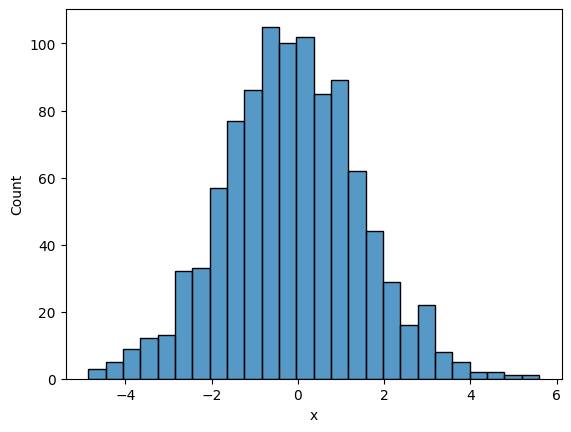

In [506]:
target = MD(prod(pos.shape))
sampler = Sampler(target)

samples = sampler.sample(1000, 1, x_initial=jnp.ones((10,)), random_key = jax.random.PRNGKey(0))


print(samples.shape)

data = pd.DataFrame(data = samples[:,0], columns=['x'])
histplot(data=data,x='x')

In [507]:
samples

Array([[-0.20574136,  0.50076469,  0.3049217 , ...,  1.60169381,
        -1.15921391, -2.54352237],
       [ 0.34518868,  0.04872355,  1.87760511, ...,  1.84992512,
        -0.95896098, -1.92207032],
       [ 0.30455644,  0.44020751,  1.98124842, ...,  0.51089947,
         0.3794461 , -0.46314269],
       ...,
       [ 1.65545037,  0.28467812,  1.84596088, ..., -1.21298695,
         1.33842253,  0.95066881],
       [ 1.09467664,  0.53757098,  0.38645324, ..., -1.4445249 ,
         1.50185841, -0.70067639],
       [-0.99773564, -0.63084634, -0.18156214, ...,  1.1652214 ,
         1.61615369, -1.96677391]], dtype=float64)